In [1530]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [1531]:
HOUSING_PATH_FULL='C:/Users/samys/PycharmProjects/HousingPrices/data/Melbourne_housing_FULL.csv'

def load_housing_data(housing_path=HOUSING_PATH_FULL):
    return pd.read_csv(housing_path)

In [1532]:
loaded_data = load_housing_data()
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [1533]:
train_val_set = loaded_data.dropna(subset=['Price'])
final_test = loaded_data[loaded_data['Price'].isna()]
print(f"Number of rows in train_val_set: {len(train_val_set)}")
print(f"Number of rows in final_test: {len(final_test)}")

new_column_names = {'Lattitude': 'Latitude', 'Longtitude': 'Longitude'}
melb_data = train_val_set.rename(columns=new_column_names)

PRICE_MEAN = melb_data['Price'].mean()
print(f'PRICE_MEAN = {PRICE_MEAN}'  )
PRICE_MEDIAN = melb_data['Price'].median()
print(f'PRICE_MEDIAN = {PRICE_MEDIAN}')

Number of rows in train_val_set: 27247
Number of rows in final_test: 7610
PRICE_MEAN = 1050173.344955408
PRICE_MEDIAN = 870000.0


In [1534]:
def remove_outliers_iqr_all(df, columns, factor=1.5):
    df_clean = df.copy()
    outlier_mask = pd.Series(False, index=df_clean.index)

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        outlier_mask |= (df_clean[col] < lower) | (df_clean[col] > upper)

    num_outliers = outlier_mask.sum()
    df_clean = df_clean[~outlier_mask]

    print(f"Total number of outliers: {num_outliers}")
    print(f"Number of rows after removal: {len(df_clean)}")
    return df_clean


In [1535]:
cols = ['Price', 'Rooms', 'Bedroom2', 'Bathroom']
melb_data = remove_outliers_iqr_all(melb_data, cols)

Total number of outliers: 1398
Number of rows after removal: 25849


In [1536]:
train_set, test_set = train_test_split(melb_data, test_size=0.2, random_state=42)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20679 entries, 22835 to 31862
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         20679 non-null  object 
 1   Address        20679 non-null  object 
 2   Rooms          20679 non-null  int64  
 3   Type           20679 non-null  object 
 4   Price          20679 non-null  float64
 5   Method         20679 non-null  object 
 6   SellerG        20679 non-null  object 
 7   Date           20679 non-null  object 
 8   Distance       20678 non-null  float64
 9   Postcode       20678 non-null  float64
 10  Bedroom2       15664 non-null  float64
 11  Bathroom       15662 non-null  float64
 12  Car            15368 non-null  float64
 13  Landsize       13515 non-null  float64
 14  BuildingArea   8014 non-null   float64
 15  YearBuilt      9075 non-null   float64
 16  CouncilArea    20677 non-null  object 
 17  Latitude       15810 non-null  float64
 18  Longitu

In [1537]:
# train_set = remove_outliers_iqr_all(train_set, cols)


train_set['Price'] = np.log1p(train_set['Price'])
test_set['Price'] = np.log1p(test_set['Price'])

In [1538]:
housing = train_set.copy()
numerical_features = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_set.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Latitude', 'Longitude', 'Propertycount']
Categorical features: ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Postcode'}>],
       [<Axes: title={'center': 'Bedroom2'}>,
        <Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>],
       [<Axes: title={'center': 'Propertycount'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

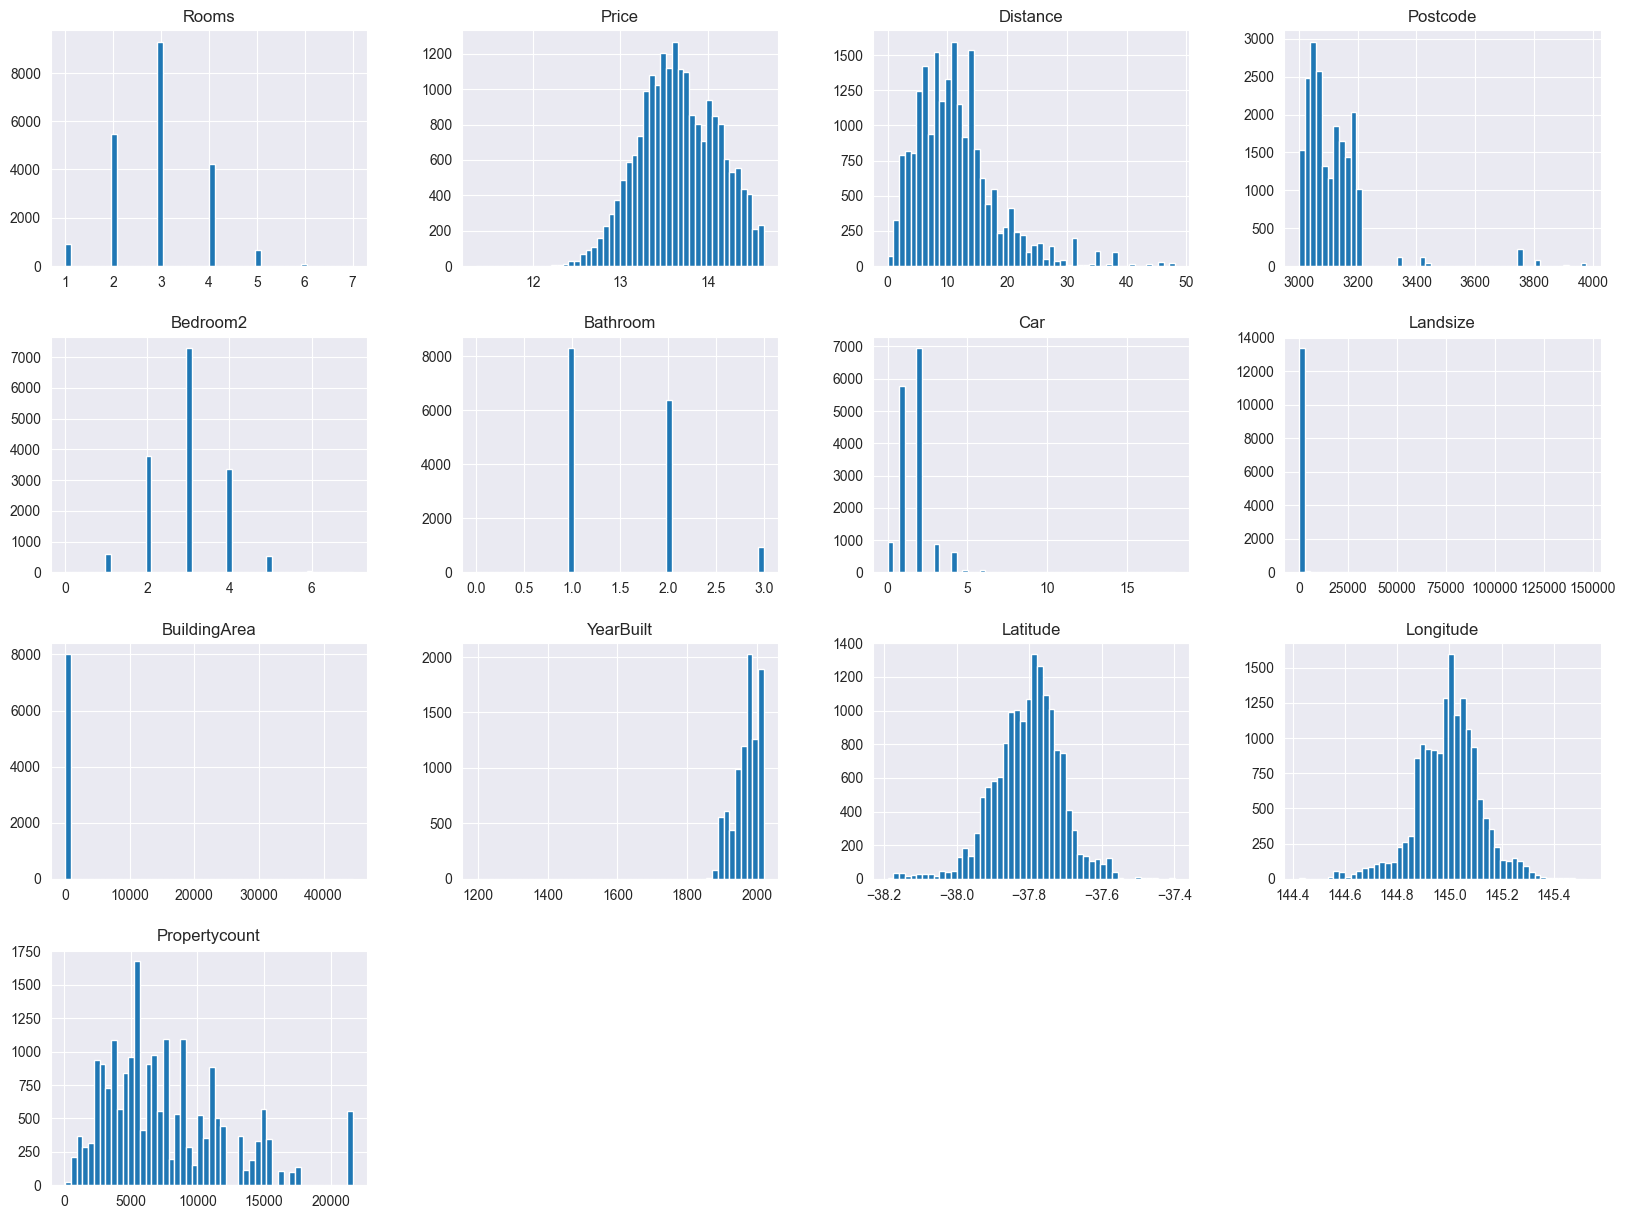

In [1539]:
housing_num = housing[numerical_features]
housing.hist(bins=50, figsize=(20, 15))

In [1540]:
corr_matrix = housing_num.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price            1.000000
Rooms            0.486589
Bedroom2         0.437093
Bathroom         0.325283
Longitude        0.255538
Car              0.181702
BuildingArea     0.074407
Landsize         0.028645
Postcode         0.010406
Propertycount   -0.095761
Distance        -0.181897
Latitude        -0.229320
YearBuilt       -0.374621
Name: Price, dtype: float64

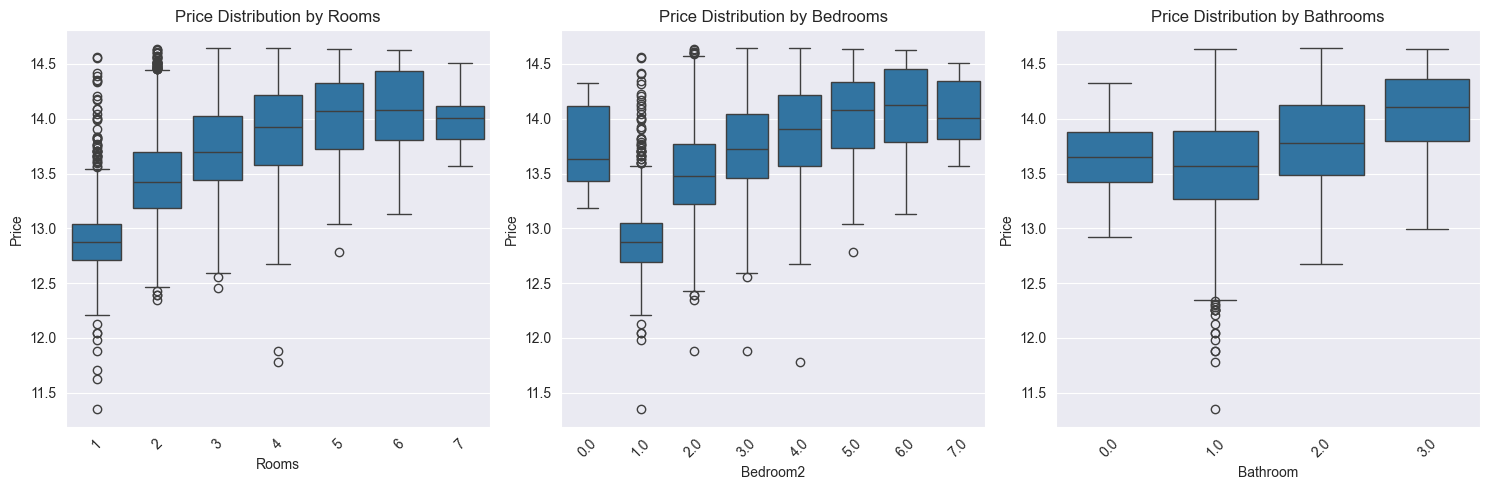

In [1541]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Price vs Rooms
sns.boxplot(data=housing, x='Rooms', y='Price', ax=axes[0])
axes[0].set_title('Price Distribution by Rooms')
axes[0].tick_params(axis='x', rotation=45)

# Price vs Bedrooms
sns.boxplot(data=housing, x='Bedroom2', y='Price', ax=axes[1])
axes[1].set_title('Price Distribution by Bedrooms')
axes[1].tick_params(axis='x', rotation=45)

# Price vs Bathrooms
sns.boxplot(data=housing, x='Bathroom', y='Price', ax=axes[2])
axes[2].set_title('Price Distribution by Bathrooms')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [1542]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Index: 20679 entries, 22835 to 31862
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         20679 non-null  object 
 1   Address        20679 non-null  object 
 2   Rooms          20679 non-null  int64  
 3   Type           20679 non-null  object 
 4   Price          20679 non-null  float64
 5   Method         20679 non-null  object 
 6   SellerG        20679 non-null  object 
 7   Date           20679 non-null  object 
 8   Distance       20678 non-null  float64
 9   Postcode       20678 non-null  float64
 10  Bedroom2       15664 non-null  float64
 11  Bathroom       15662 non-null  float64
 12  Car            15368 non-null  float64
 13  Landsize       13515 non-null  float64
 14  BuildingArea   8014 non-null   float64
 15  YearBuilt      9075 non-null   float64
 16  CouncilArea    20677 non-null  object 
 17  Latitude       15810 non-null  float64
 18  Longitu

In [1543]:

drop_cols = ["BuildingArea", "YearBuilt", "Postcode", "Latitude", "Longitude", "Address"]
housing_clean = housing.drop(columns=drop_cols)

important_dropna_cols = ["Distance", "CouncilArea", "Regionname","Bedroom2", "Bathroom", "Car"]
housing_clean = housing_clean.dropna(subset=important_dropna_cols)

median_impute_cols = ["Landsize"]
mean_impute_cols = ["Propertycount"]

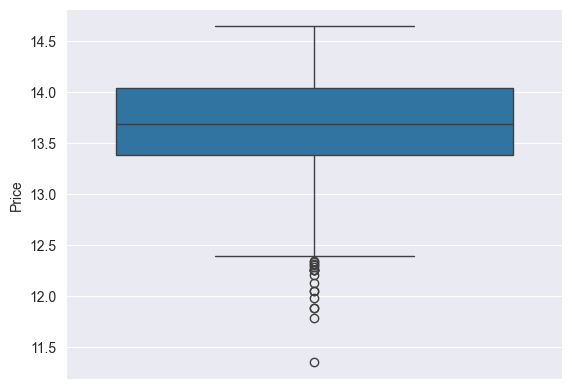

In [1544]:

sns.boxplot(data=housing_clean, y='Price')
plt.show()

In [1545]:

median_imputer = SimpleImputer(strategy="median")
mean_imputer = SimpleImputer(strategy="mean")

imputer_transform = ColumnTransformer(transformers=[
    ("median_imputer", median_imputer, median_impute_cols),
    ("mean_imputer", mean_imputer, mean_impute_cols)
],
    remainder="passthrough",
    verbose_feature_names_out=False)

numerical_cols = housing_clean.select_dtypes(include=['int64', 'float64']).columns.drop('Price').tolist()
categorical_cols = housing_clean.drop(columns=numerical_cols + ['Price']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('imputer_transform', imputer_transform),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])


Numerical columns: ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']
Categorical columns: ['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


In [1546]:
X_train = housing_clean.drop(columns=["Price"])
Y_train = housing_clean["Price"]

X_train_transformed = pipeline.fit_transform(X_train)


In [1547]:

test_set_clean = test_set.drop(columns=drop_cols)
test_set_clean = test_set_clean.dropna(subset=important_dropna_cols)


X_test = test_set_clean.drop(columns=["Price"])
Y_test = test_set_clean["Price"]

X_test_transformed = pipeline.transform(test_set_clean)


In [1548]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [1549]:

models = {
    # 'Linear': LinearRegression(),
    # 'Ridge': Ridge(alpha=1.0),
    # 'Lasso': Lasso(alpha=0.01),
    # 'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    # 'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    # 'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    # 'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}




In [1550]:
preds = {}

for name, model in models.items():
    model.fit(X_train_transformed, Y_train)
    pred = model.predict(X_test_transformed)
    preds[name] = pred


In [1551]:
def print_error(name, y_pred_log):
    print('---------------------------------------------------------\n')
    print(f'Model: {name}')
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(Y_test)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Выводим результаты
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R²: {r2}")
    print(f"Predicted/Price Error: {(mae / PRICE_MEDIAN * 100):.2f} %")

In [1552]:
for name, pred in preds.items():
    print_error(name, pred)

---------------------------------------------------------

Model: CatBoost
Mean Absolute Error (MAE): 127464.47750394294
Mean Squared Error (MSE): 32949152825.187748
Root Mean Squared Error (RMSE): 181519.01505128256
R²: 0.8297410187551246
Predicted/Price Error: 14.65 %


In [1553]:
def crossValidationFit():
    # Create scorers for multiple metrics
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    # Set up k-fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation for different metrics
    rmse_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                  scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                scoring=r2_scorer, cv=kf)
    mae_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                 scoring='neg_mean_absolute_error', cv=kf)


    print("Cross-validation results:")
    print(f"RMSE scores: {-rmse_scores}")  # Negative because scorer is negative for minimization
    print(f"Average RMSE: {-rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")
    print(f"\nR² scores: {r2_scores}")
    print(f"Average MAE: {r2_scores.mean():.4f} (+/- {r2_scores.std() * 2:.4f})")
    print(f"\nMAE scores: {mae_scores}")
    print(f"Average MAE: {mae_scores.mean():.4f} (+/- {mae_scores.std() * 2:.4f})")


In [1554]:
# crossValidationFit()

In [1555]:
good_model = models['CatBoost']

random_house = test_set_clean.sample(n=5)

display(random_house)

random_house_X = random_house.drop(columns=["Price"])
random_house_Y = random_house["Price"]

random_house_transformed = pipeline.transform(random_house_X)
random_prediction = good_model.predict(random_house_transformed)

for i, price in enumerate(random_house_Y):
    print(f'True value : {np.expm1(price)}')
    print(f'Predicted value : {np.expm1(random_prediction[i])}')
    print(f'Error : {abs(np.expm1(price) - np.expm1(random_prediction[i]))}')
    print('---------------------------------------------')


,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Bedroom2,Bathroom,Car,Landsize,CouncilArea,Regionname,Propertycount
15175,Murrumbeena,2,u,13.308014,S,hockingstuart,3/06/2017,10.1,2.0,1.0,1.0,1166.0,Glen Eira City Council,Southern Metropolitan,4442.0
24038,Roxburgh Park,3,h,13.122365,S,Raine,7/10/2017,20.6,3.0,2.0,2.0,NaN,Hume City Council,Northern Metropolitan,5833.0
3121,Caulfield South,3,h,14.088587,S,Gary,10/09/2016,9.3,3.0,1.0,2.0,339.0,Glen Eira City Council,Southern Metropolitan,5051.0
11066,Brunswick East,4,h,14.070154,S,Jellis,11/03/2017,4.5,4.0,2.0,2.0,468.0,Moreland City Council,Northern Metropolitan,5533.0
21085,Clarinda,4,t,13.689948,S,C21,16/09/2017,17.5,4.0,2.0,3.0,NaN,Kingston City Council,South-Eastern Metropolitan,2727.0


True value : 602000.0000000005
Predicted value : 588931.8002959534
Error : 13068.19970404706
---------------------------------------------
True value : 499999.99999999977
Predicted value : 547743.9027238012
Error : 47743.90272380144
---------------------------------------------
True value : 1314000.0000000002
Predicted value : 1197682.4908219196
Error : 116317.5091780806
---------------------------------------------
True value : 1290000.0000000007
Predicted value : 1612302.3992569337
Error : 322302.399256933
---------------------------------------------
True value : 881999.9999999999
Predicted value : 937241.1789774288
Error : 55241.178977428935
---------------------------------------------


In [1556]:
from scipy.stats import uniform, randint

def randomSearchFit():
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    param_dist = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'iterations': [200, 500, 1000],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }

    param_random_prof = {
        'iterations': randint(500, 1500),                    # с расчетом на раннюю остановку
        'learning_rate': uniform(0.01, 0.3),                 # от 0.01 до 0.31
        'depth': randint(4, 11),                             # от 4 до 10
        'l2_leaf_reg': uniform(1, 9),                        # от 1 до 10
        'bagging_temperature': uniform(0, 1.5),              # от 0 до 1.5
        'random_strength': uniform(0, 10),                   # от 0 до 10
        'rsm': uniform(0.5, 0.5),                            # от 0.5 до 1.0
        'subsample': uniform(0.6, 0.4),                      # от 0.6 до 1.0
        'scale_pos_weight': uniform(0.5, 4.5),               # от 0.5 до 5.0 (только для бинарной классификации)
    }


    cat = CatBoostRegressor(verbose=0, random_state=42)

    search = RandomizedSearchCV(
        cat,
        param_distributions=param_dist,
        n_iter=20,
        scoring=rmse_scorer,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train_transformed, Y_train)

    print("Лучшие параметры:", search.best_params_)
    print("Лучшее значение RMSE (на CV):", -search.best_score_)


    best_model = search.best_estimator_

    y_pred_log = best_model.predict(X_test_transformed)

    print_error("CatBoost (поиск по сетке)", y_pred_log)


In [1557]:
# randomSearchFit()

In [1558]:

def gridSearchFit():
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cat_grid = CatBoostRegressor(verbose=0, random_state=42)

    param_grid_prof = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [0, 1, 5, 10],
    'rsm': [0.5, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3, 5]  # применимо только при дисбалансе классов в бинарной классификации
    }


    param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 300, 500]
    }

    grid_search = GridSearchCV(
        estimator=cat_grid,
        param_grid=param_grid,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1
    )

    grid_search.fit(X_train_transformed, Y_train)
    print("Лучшая комбинация гиперпараметров:")
    print(grid_search.best_params_)

    print("\nЛучший (наименьший) RMSE (по CV):")
    print(f"{-grid_search.best_score_:.4f}")
    best_model = grid_search.best_estimator_

    grid_predict = best_model.predict(X_test_transformed)

    print_error("GridSearch CatBoost (поиск по сетке)", grid_predict)

In [1559]:
# gridSearchFit()